In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vwadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vwadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# dataset
The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

This module contains two loaders. The first one, **sklearn.datasets.fetch_20newsgroups**, returns a list of the raw texts that can be fed to text feature extractors extract feature vectors. The second one, **sklearn.datasets.fetch_20newsgroups_vectorized**, returns ready-to-use features, i.e., it is not necessary to use a feature extractor.

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [3]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
newsgroup_all=fetch_20newsgroups()
newsgroups_train.target.shape

(11314,)

In [5]:
newsgroups_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [6]:
np.unique(newsgroups_train.target, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
        594, 593, 599, 546, 564, 465, 377], dtype=int64))

In [7]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

In [8]:
labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


### Perform Lemmatization

In [9]:
lemmatizer = WordNetLemmatizer()
for i in range(len(dataset.data)):
    word_list = word_tokenize(dataset.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    dataset.data[i] = lemmatized_doc

In [10]:
print(dataset.data[1])

 By ' 8 grey level image ' you mean 8 item of 1bit image ? It doe work ( ! ) , but it doe n't work if you have more than 1bit in your screen and if the screen intensity is non-linear . With 2 bit per pixel ; there could be 1 * c_1 + 4 * c_2 timing , this give 16 level , but they are linear if screen intensity is linear . With 1 * c_1 + 2 * c_2 it work , but we have to find the best compinations -- there 's 10 level , but 16 choises ; best 10 must be chosen . Different compinations for the same level , varies a bit , but the level keep their order . Readers should verify what I wrote ... : - )


# Converting to vectors
In order to feed predictive or clustering models with the text data, one first need to turn the text into vectors of numerical values suitable for statistical analysis.

In [11]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2) ## Corpus is in English
X = vectorizer.fit_transform(dataset.data)

In [12]:
print(X.shape)

(3387, 16549)


### Clustering using standard k-means

In [13]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

C:\Users\vwadhawan\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


done in 3.413s


### Identify the 10 most relevant terms in each cluster

In [14]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: space wa shuttle orbit launch nasa mission moon satellite cost
Cluster 1: god wa people jesus say doe religion believe belief think
Cluster 2: file image thanks format program graphic know color gif ftp
Cluster 3: wa just think like ha did know time people good


In [15]:
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [16]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [17]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

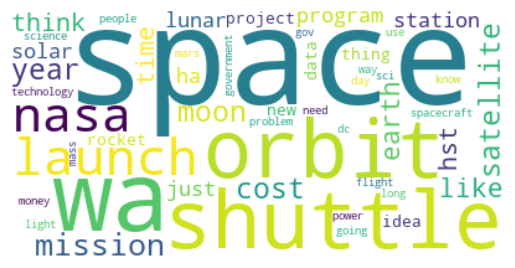

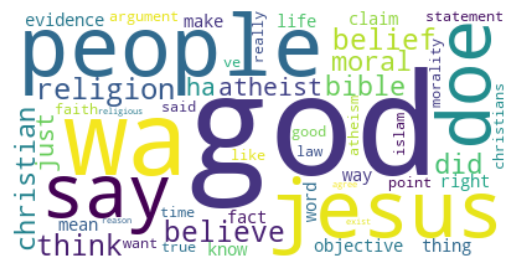

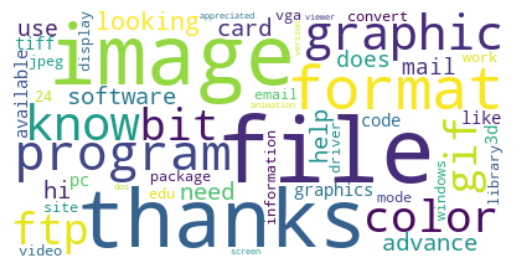

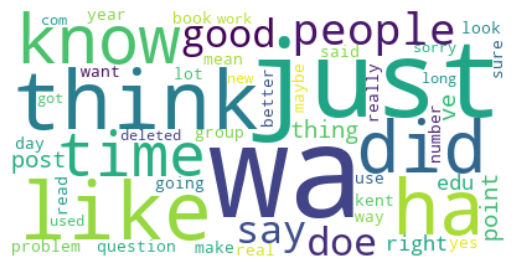

In [18]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()

# Exercise
Take all 20 news group data and perfrom DBSCAN. compare your predicted labels with actual labels and show accuracy of DBSCAN.